# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
import wandb
from torchvision.transforms import AutoAugment, AutoAugmentPolicy


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Class

In [2]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        # 데이터셋의 기본 경로, 이미지 변환 방법, 이미지 경로 및 레이블을 초기화합니다.
        self.root_dir = root_dir  # 이미지 파일들이 저장된 기본 디렉토리
        self.transform = transform  # 이미지에 적용될 변환 처리
        self.is_inference = is_inference # 추론인지 확인
        self.image_paths = info_df['image_path'].tolist()  # 이미지 파일 경로 목록
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()  # 각 이미지에 대한 레이블 목록

    def __len__(self) -> int:
        # 데이터셋의 총 이미지 수를 반환합니다.
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        # 주어진 인덱스에 해당하는 이미지를 로드하고 변환을 적용한 후, 이미지와 레이블을 반환합니다.
        img_path = os.path.join(self.root_dir, self.image_paths[index])  # 이미지 경로 조합
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 이미지를 BGR 컬러 포맷의 numpy array로 읽어옵니다.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
        image = self.transform(image)  # 설정된 이미지 변환을 적용합니다.

        if self.is_inference:
            return image
        else:
            target = self.targets[index]  # 해당 이미지의 레이블
            return image, target  # 변환된 이미지와 레이블을 튜플 형태로 반환합니다. 

# Transform Class

In [3]:
class TorchvisionTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 텐서 변환, 정규화
        common_transforms = [
            transforms.Resize((224, 224)),  # 이미지를 224x224 크기로 리사이즈
            transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 색상 조정 추가
            self.transform = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    transforms.RandomRotation(15),  # 최대 15도 회전
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = transforms.Compose(common_transforms)

    def __call__(self, image: np.ndarray) -> torch.Tensor:
        image = Image.fromarray(image)  # numpy 배열을 PIL 이미지로 변환
        
        transformed = self.transform(image)  # 설정된 변환을 적용
        
        return transformed  # 변환된 이미지 반환

In [4]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        
        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    # Geometric transformations
                    A.Rotate(limit=10, p=0.5),
                    A.Affine(scale=(0.8, 1.2), shear=(-10, 10), p=0.5),
                    A.ElasticTransform(alpha=0.5, sigma=5, p=0.5),

                    ## Morphological transformations
                    #A.Erosion(kernel=(1, 2), p=0.5),
                    #A.Dilation(kernel=(1, 2), p=0.5),

                    # Noise and blur
                    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                    A.MotionBlur(blur_limit=(3, 7), p=0.5),

                    # Sketch-specific augmentations
                    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=255, p=0.5),

                    # Advanced techniques
                    A.OneOf([
                        # A.AutoContrast(p=0.5),
                        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
                    ], p=0.5),
                    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5)
                ] + common_transforms
            )
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")
        
        # 이미지에 변환 적용 및 결과 반환
        transformed = self.transform(image=image)  # 이미지에 설정된 변환을 적용
        
        return transformed['image']  # 변환된 이미지의 텐서를 반환

In [5]:
class TransformSelector:
    """
    이미지 변환 라이브러리를 선택하기 위한 클래스.
    """
    def __init__(self, transform_type: str):

        # 지원하는 변환 라이브러리인지 확인
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        
        # 선택된 라이브러리에 따라 적절한 변환 객체를 생성
        if self.transform_type == 'torchvision':
            transform = TorchvisionTransform(is_train=is_train)
        
        elif self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        
        return transform

# Model Class

In [6]:
class SimpleCNN(nn.Module):
    """
    간단한 CNN 아키텍처를 정의하는 클래스.
    """
    def __init__(self, num_classes: int):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # 순전파 함수 정의
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [7]:
class TorchvisionModel(nn.Module):
    """
    Torchvision에서 제공하는 사전 훈련된 모델을 사용하는 클래스.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TorchvisionModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=pretrained)
        
        # 모델의 최종 분류기 부분을 사용자 정의 클래스 수에 맞게 조정
        if 'fc' in dir(self.model):
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        
        elif 'classifier' in dir(self.model):
            num_ftrs = self.model.classifier[-1].in_features
            self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        return self.model(x)

In [8]:
# class TimmModel(nn.Module):
#     """
#     Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
#     """
#     def __init__(
#         self, 
#         model_name: str, 
#         num_classes: int, 
#         pretrained: bool
#     ):
#         super(TimmModel, self).__init__()
#         self.model = timm.create_model(
#             model_name, 
#             pretrained=pretrained, 
#             num_classes=num_classes
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
        
#         return self.model(x)

# class TimmModel(nn.Module):
#     """
#     Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
#     """
#     def __init__(
#         self, 
#         model_name: str, 
#         num_classes: int, 
#         pretrained: bool,
#         dropout_rate: float = 0.5  # Dropout 비율 추가
#     ):
#         super(TimmModel, self).__init__()
#         self.model = timm.create_model(
#             model_name, 
#             pretrained=pretrained
#         )
        
#         # Dropout 레이어 추가
#         self.dropout = nn.Dropout(p=dropout_rate)
        
#         # 마지막 레이어 수정
#         in_features = self.model.get_classifier().in_features  # 마지막 레이어의 입력 차원 가져오기
#         self.model.reset_classifier(num_classes=num_classes)  # 기존 분류기 초기화

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.model(x)  # 기본 모델의 forward pass
#         x = self.dropout(x)  # Dropout 적용
#         return x

class TimmModel(nn.Module):
    """
    Timm 라이브러리를 사용하여 다양한 사전 훈련된 모델을 제공하는 클래스.
    CLIP의 이미지 인코더를 ConvNeXt 모델에 결합하여 사용.
    """
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool,
        dropout_rate: float = 0.5,  # Dropout 비율 추가
        use_clip: bool = False  # CLIP 사용 여부 추가
    ):
        super(TimmModel, self).__init__()

        # 1. CLIP 이미지 인코더 사용 여부에 따라 모델 초기화
        if use_clip:
            # CLIP 모델에서 이미지 인코더 가져오기
            clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            clip_model.load_state_dict(torch.load('train_result/clip/clip_1e-05/clip_1e-05.pt'))
            self.image_encoder = clip_model.vision_model

            # ConvNeXt 모델 불러오기
            self.convnext_model = timm.create_model('convnext_base', pretrained=False, num_classes=num_classes)
        else:
            # 일반 timm 모델 (예시: ConvNeXt)
            self.convnext_model = timm.create_model(model_name, pretrained=pretrained)

        # Dropout 레이어 추가
        self.dropout = nn.Dropout(p=dropout_rate)

        # 마지막 레이어 수정
        in_features = self.convnext_model.get_classifier().in_features
        self.convnext_model.reset_classifier(num_classes=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if hasattr(self, 'image_encoder'):
            # CLIP 이미지 인코더가 있는 경우, 먼저 이를 통과시킴
            x = self.image_encoder(x).last_hidden_state

        # ConvNeXt 또는 기본 모델 통과
        x = self.convnext_model(x)

        # Dropout 적용
        x = self.dropout(x)
        return x

    def freeze_all_parameters(self):
        # 모든 파라미터를 고정
        for param in self.parameters():
            param.requires_grad = False

    def unfreeze_last_layer(self):
        # 마지막 레이어만 학습 가능하게 설정 (예시: ConvNeXt의 head 부분)
        self.convnext_model.head.requires_grad = True

In [9]:
class ModelSelector:
    """
    사용할 모델 유형을 선택하는 클래스.
    """
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        
        # 모델 유형에 따라 적절한 모델 객체를 생성
        if model_type == 'simple':
            self.model = SimpleCNN(num_classes=num_classes)
        
        elif model_type == 'torchvision':
            self.model = TorchvisionModel(num_classes=num_classes, **kwargs)
        
        elif model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:

        # 생성된 모델 객체 반환
        return self.model

# Loss Class

In [10]:
# class Loss(nn.Module):
#     """
#     모델의 손실함수를 계산하는 클래스.
#     """
#     def __init__(self):
#         super(Loss, self).__init__()
#         self.loss_fn = nn.CrossEntropyLoss()

#     def forward(
#         self, 
#         outputs: torch.Tensor, 
#         targets: torch.Tensor
#     ) -> torch.Tensor:
    
#         return self.loss_fn(outputs, targets)

class Loss(nn.Module):
    """
    모델의 손실함수를 계산하는 클래스.
    """
    def __init__(self, label_smoothing=0.05):
        super(Loss, self).__init__()
        self.label_smoothing = label_smoothing

    def label_smoothed_nll_loss(self, lprobs, target):
        nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1))  # Negative log likelihood
        nll_loss = nll_loss.squeeze(-1)  # Remove last dimension
        smooth_loss = -lprobs.mean(dim=-1)  # Average log probability
        loss = (1.0 - self.label_smoothing) * nll_loss + self.label_smoothing * smooth_loss  # Combine NLL and smoothed loss
        return loss.mean()

    def forward(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Softmax를 사용하여 로그 확률 계산
        lprobs = F.log_softmax(outputs, dim=-1)
        
        # 스무딩 적용한 손실 계산
        return self.label_smoothed_nll_loss(lprobs, targets)

# Trainer Class

In [11]:
class Trainer:
    def __init__(
        self, 
        model: nn.Module, 
        device: torch.device, 
        train_loader: DataLoader, 
        val_loader: DataLoader, 
        optimizer: optim.Optimizer,
        scheduler: optim.lr_scheduler,
        loss_fn: torch.nn.modules.loss._Loss, 
        epochs: int,
        result_path: str,
        patience: int = 5  # 조기 종료를 위한 patience 설정
    ):
        # 클래스 초기화: 모델, 디바이스, 데이터 로더 등 설정
        self.model = model  # 훈련할 모델
        self.device = device  # 연산을 수행할 디바이스 (CPU or GPU)
        self.train_loader = train_loader  # 훈련 데이터 로더
        self.val_loader = val_loader  # 검증 데이터 로더
        self.optimizer = optimizer  # 최적화 알고리즘
        self.scheduler = scheduler # 학습률 스케줄러
        self.loss_fn = loss_fn  # 손실 함수
        self.epochs = epochs  # 총 훈련 에폭 수
        self.result_path = result_path  # 모델 저장 경로
        self.best_models = [] # 가장 좋은 상위 3개 모델의 정보를 저장할 리스트
        self.lowest_train_loss = float('inf') # 가장 낮은 Loss를 저장할 변수
        self.lowest_val_loss = float('inf')
        self.lowest_loss = float('inf')
        self.patience = patience  # 조기 종료를 위한 patience
        self.early_stop_counter = 0
        self.best_val_accuracy = 0.0  # 최고 검증 정확도 초기화

        # 학습 기록 저장을 위한 리스트
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def accuracy_fn(self, outputs, targets):
        """정확도 계산 함수"""
        _, preds = torch.max(outputs, 1)
        corrects = torch.sum(preds == targets)
        accuracy = corrects.double() / len(targets)
        return accuracy.item()
        
    def save_model(self, epoch, loss):
        # 모델 저장 경로 설정
        os.makedirs(self.result_path, exist_ok=True)

        # 현재 에폭 모델 저장
        current_model_path = os.path.join(self.result_path, f'model_epoch_{epoch}_loss_{loss:.4f}.pt')
        torch.save(self.model.state_dict(), current_model_path)

        # 최상위 3개 모델 관리
        self.best_models.append((loss, epoch, current_model_path))
        self.best_models.sort()
        if len(self.best_models) > 3:
            _, _, path_to_remove = self.best_models.pop(-1)  # 가장 높은 손실 모델 삭제
            if os.path.exists(path_to_remove):
                os.remove(path_to_remove)

        # 가장 낮은 손실의 모델 저장
        if loss < self.lowest_loss:
            self.lowest_loss = loss
            best_model_path = os.path.join(self.result_path, 'best_model.pt')
            torch.save(self.model.state_dict(), best_model_path)
            print(f"Save {epoch+1}epoch result. Loss = {loss:.4f}")

    def load_model(self, model_path: str):
        """모델을 불러오는 함수"""
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)
        print(f"Model loaded from {model_path}")

    def train_epoch(self) -> (float, float):
        # 한 에폭 동안의 훈련을 진행
        self.model.train()
        total_loss = 0.0
        corrects = 0
        total = 0

        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)
        for images, targets in progress_bar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_fn(outputs, targets)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            corrects += torch.sum(torch.max(outputs, 1)[1] == targets).item()
            total += targets.size(0)
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(self.train_loader)
        accuracy = corrects / total
        return avg_loss, accuracy

    def validate(self) -> (float, float):
        # 모델의 검증을 진행
        self.model.eval()
        total_loss = 0.0
        corrects = 0
        total = 0

        progress_bar = tqdm(self.val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, targets in progress_bar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                loss = self.loss_fn(outputs, targets)

                total_loss += loss.item()
                corrects += torch.sum(torch.max(outputs, 1)[1] == targets).item()
                total += targets.size(0)
                progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(self.val_loader)
        accuracy = corrects / total
        return avg_loss, accuracy

    def train(self, load_model: bool = False, model_path: str = None) -> None:
        if load_model and model_path:
            self.load_model(model_path)

        # 전체 훈련 과정을 관리
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
            print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n")

            # Loss 및 Accuracy 기록
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # 모델 저장
            self.save_model(epoch, val_loss)

            # Early Stopping
            if val_loss < self.lowest_val_loss:
                self.lowest_val_loss = val_loss
                self.early_stop_counter = 0  # 검증 손실이 감소하면 카운터 리셋
                print(f"Lowest loss updated to {self.lowest_val_loss:.4f}. Early stop counter reset to 0.")
            else:
                self.early_stop_counter += 1  # 감소하지 않으면 카운터 증가
                if self.early_stop_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch+1}.")
                    break
            # if val_acc > self.best_val_accuracy:
            #     self.best_val_accuracy = val_acc
            #     self.early_stop_counter = 0  # 검증 정확도가 증가하면 카운터 리셋
            # else:
            #     self.early_stop_counter += 1  # 증가하지 않으면 카운터 증가
            #     if self.early_stop_counter >= self.patience:
            #         print(f"Early stopping at epoch {epoch+1}.")
            #         break

            self.scheduler.step(val_loss)

            # 매 에폭마다 그래프 시각화
            self.plot_results()

        # 최종 그래프 시각화 (전체 학습이 끝난 후에도 그래프를 그릴 수 있음)
        self.plot_results()

    def plot_results(self):
        """학습 결과 시각화 (Loss & Accuracy)"""
        epochs_range = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(14, 10))

        # Loss 시각화
        plt.subplot(2, 1, 1)
        plt.plot(epochs_range, self.train_losses, label="Train Loss", color='blue')
        plt.plot(epochs_range, self.val_losses, label="Validation Loss", color='red')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")
        plt.title("Train & Validation Loss")

        # Accuracy 시각화
        plt.subplot(2, 1, 2)
        plt.plot(epochs_range, self.train_accuracies, label="Train Accuracy", color='green')
        plt.plot(epochs_range, self.val_accuracies, label="Validation Accuracy", color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")
        plt.title("Train & Validation Accuracy")

        plt.tight_layout()
        plt.show()        

# Model Training

In [12]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/data/train"
traindata_info_file = "/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/data/train.csv"
save_result_path = "/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/train_result"

In [14]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

In [15]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False
)

In [16]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='convnext_base', 
    pretrained=False
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (convnext_model): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (

In [17]:
# # 학습에 사용할 optimizer를 선언하고, learning rate를 지정
# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=0.001
# )

# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-4,
    weight_decay=1e-4
)

In [18]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.5  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [19]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [20]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=5,
    result_path=save_result_path
)

Epoch 1/5


Epoch 1, Train Loss: 6.4183, Train Accuracy: 0.0022
Epoch 1, Validation Loss: 6.2546, Validation Accuracy: 0.0037

Save 1epoch result. Loss = 6.2546
Lowest loss updated to 6.2546. Early stop counter reset to 0.


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


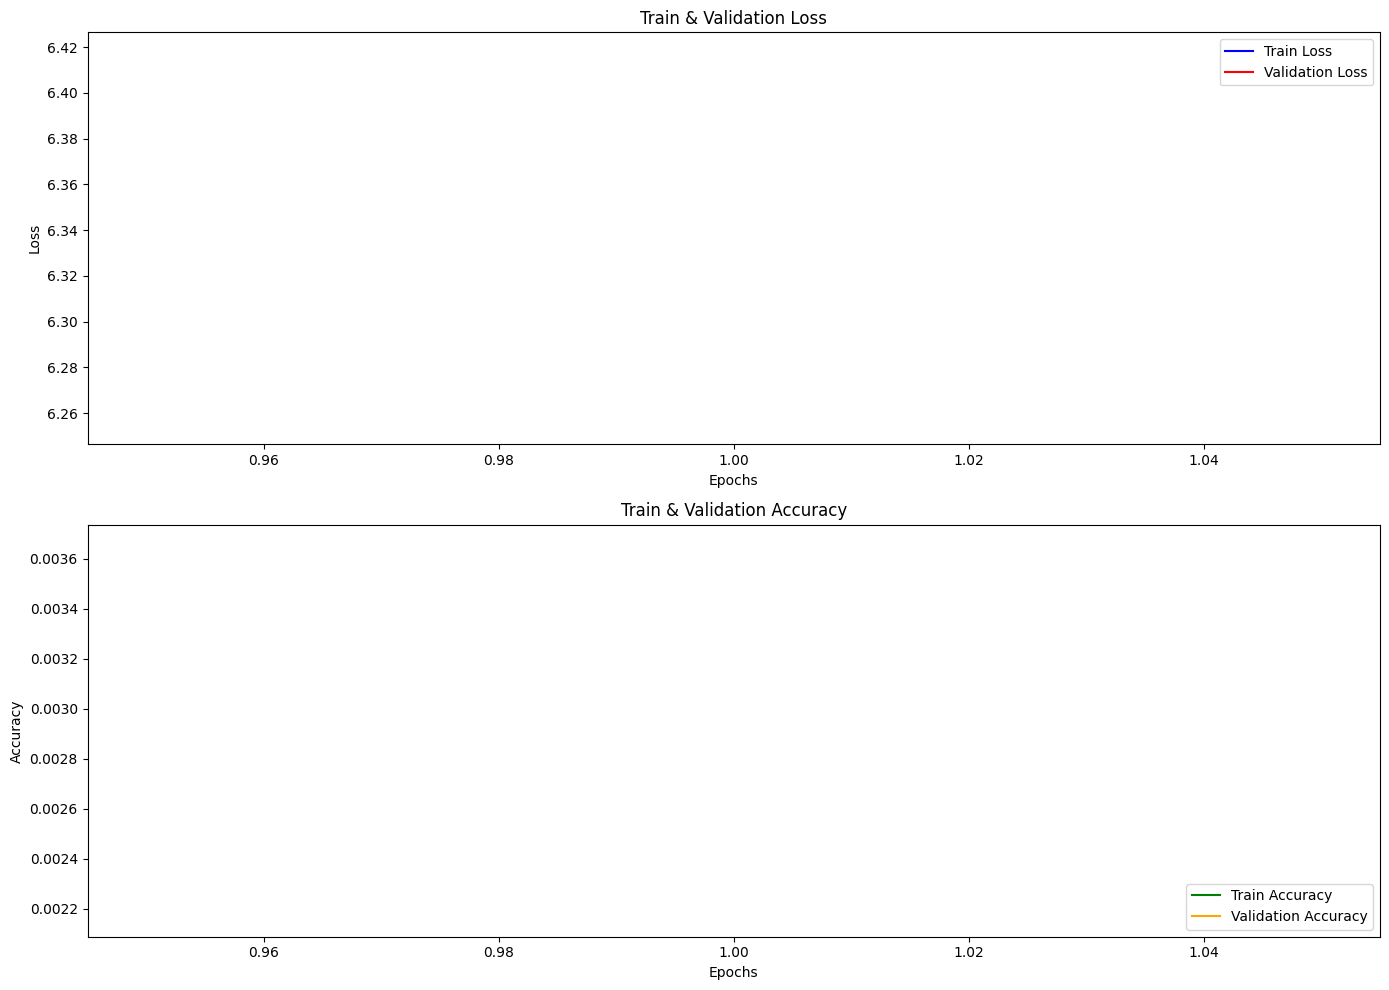

Epoch 2/5


Epoch 2, Train Loss: 6.2982, Train Accuracy: 0.0023
Epoch 2, Validation Loss: 6.2252, Validation Accuracy: 0.0030

Save 2epoch result. Loss = 6.2252
Lowest loss updated to 6.2252. Early stop counter reset to 0.


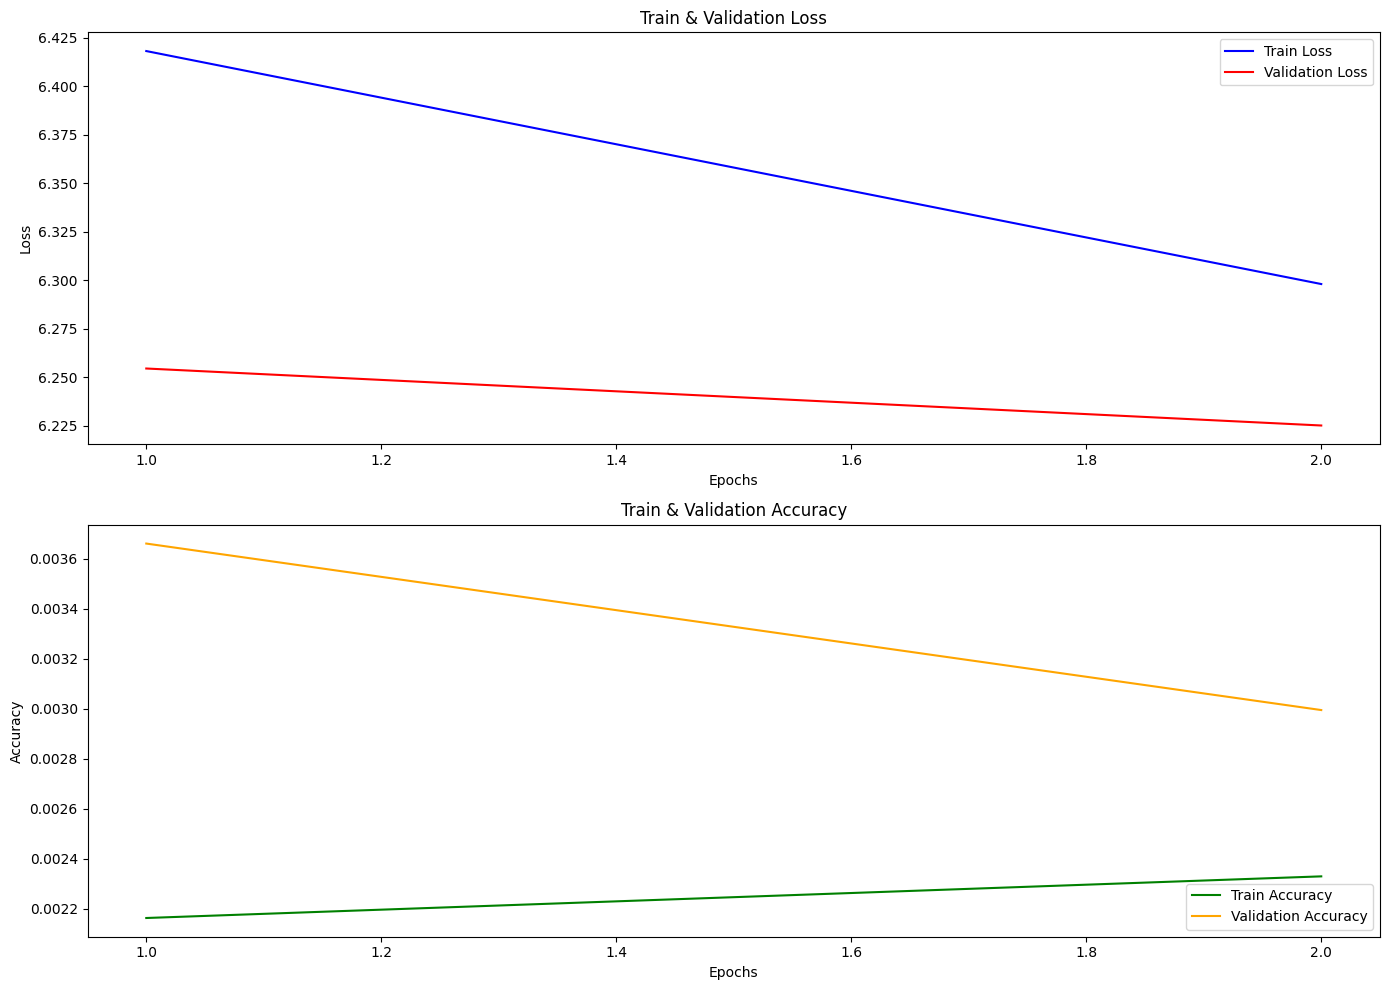

Epoch 3/5


KeyboardInterrupt: 

In [21]:
# 모델 학습.
trainer.train()

# Inference

In [23]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [24]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [25]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [26]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "albumentations"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [27]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet18', 
    pretrained=False
)
model = model_selector.get_model()


In [28]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

C:\Users\zin\AppData\Local\Temp\ipykernel_21932\1021875342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


<All keys matched successfully>

In [29]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

In [30]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,328
1,1,1.JPEG,414
2,2,2.JPEG,205
3,3,3.JPEG,17
4,4,4.JPEG,388
...,...,...,...
10009,10009,10009.JPEG,235
10010,10010,10010.JPEG,111
10011,10011,10011.JPEG,219
10012,10012,10012.JPEG,400


In [31]:
# DataFrame 저장
test_info.to_csv("output.csv", index=False)